In [61]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math
from skorch import NeuralNetClassifier
import torch
import torch.nn as nn
#sklearn onehotencoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV


import warnings
warnings.filterwarnings("ignore")

from sklearn.impute import KNNImputer
impute = KNNImputer()

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, log_loss


from skorch import NeuralNetBinaryClassifier
from skorch.callbacks import Callback, EarlyStopping, EpochScoring

In [62]:
df=pd.read_csv("speeddating.csv", sep=",")
df.columns

Index(['has_null', 'wave', 'gender', 'age', 'age_o', 'd_age', 'd_d_age',
       'race', 'race_o', 'samerace',
       ...
       'd_expected_num_interested_in_me', 'd_expected_num_matches', 'like',
       'guess_prob_liked', 'd_like', 'd_guess_prob_liked', 'met', 'decision',
       'decision_o', 'match'],
      dtype='object', length=123)

EDA

In [63]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
has_null,8378.0,0.874910,0.330840,0.0,1.0,1.0,1.0,1.0
wave,8378.0,11.350919,5.995903,1.0,7.0,11.0,15.0,21.0
d_age,8378.0,4.185605,4.596171,0.0,1.0,3.0,5.0,37.0
samerace,8378.0,0.395799,0.489051,0.0,0.0,0.0,1.0,1.0
decision,8378.0,0.419909,0.493573,0.0,0.0,0.0,1.0,1.0
decision_o,8378.0,0.419551,0.493515,0.0,0.0,0.0,1.0,1.0
match,8378.0,0.164717,0.370947,0.0,0.0,0.0,0.0,1.0


In [64]:
df.describe(exclude=np.number)

,gender,age,age_o,d_d_age,race,race_o,importance_same_race,importance_same_religion,d_importance_same_race,d_importance_same_religion,...,expected_num_interested_in_me,expected_num_matches,d_expected_happy_with_sd_people,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met
count,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,...,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378
unique,2,31,25,4,6,6,18,16,3,3,...,19,18,3,3,3,19,20,3,3,8
top,male,27,27,[2-3],European/Caucasian-American,European/Caucasian-American,1,1,[2-5],[0-1],...,?,2,[5-6],[0-3],[0-2],7,5,[6-8],[5-6],0
freq,4194,1037,1059,2406,4727,4722,2754,2944,3104,3111,...,6578,1695,4036,7346,4514,1816,1799,4827,3199,7644


In [65]:
#Pozrel som sa ako vyzerajú dáta
df.age.unique()

array(['21', '24', '25', '23', '22', '26', '27', '30', '28', '?', '29',
       '34', '35', '32', '39', '20', '19', '18', '37', '33', '36', '31',
       '42', '38', '55', 23, 24, 30, 28, 27, 25], dtype=object)

In [66]:
#kukol som či tu sú duplikáty
print("Duplicates:")
duplicates = df.duplicated()
print(df[duplicates])


Duplicates:
Empty DataFrame
Columns: [has_null, wave, gender, age, age_o, d_age, d_d_age, race, race_o, samerace, importance_same_race, importance_same_religion, d_importance_same_race, d_importance_same_religion, field, pref_o_attractive, pref_o_sincere, pref_o_intelligence, pref_o_funny, pref_o_ambitious, pref_o_shared_interests, d_pref_o_attractive, d_pref_o_sincere, d_pref_o_intelligence, d_pref_o_funny, d_pref_o_ambitious, d_pref_o_shared_interests, attractive_o, sinsere_o, intelligence_o, funny_o, ambitous_o, shared_interests_o, d_attractive_o, d_sinsere_o, d_intelligence_o, d_funny_o, d_ambitous_o, d_shared_interests_o, attractive_important, sincere_important, intellicence_important, funny_important, ambtition_important, shared_interests_important, d_attractive_important, d_sincere_important, d_intellicence_important, d_funny_important, d_ambtition_important, d_shared_interests_important, attractive, sincere, intelligence, funny, ambition, d_attractive, d_sincere, d_intelligence

Okej, máme missing values v podobe '?' ale nie duplikáty

In [67]:
# Nahrada NaN/<NA> za ?, oprava rôznych data typov v stĺpci, následna oprava opravy naspäť na int z float(kvôli NaN)
df = df.replace("?", np.nan)


#Keďže dropnutie všetkých NaN spôsobí stratu 80% dát, treba imputovať kde sa dá

# match, gender, akékoľvek descison či age sa nedá/nemá zmysel imputovať
# predpokladám že veľmi podstatné pre match bude ako vidí človek druhého človeka, teda nebudem imputovať ani určité vlastnsti s '_o'
critical = [
    'match',
    'gender',
    'age',
    'age_o',
    'decision',
    'decision_o',
    'attractive_o',
    'sinsere_o',
    'intelligence_o',
    'funny_o',
    'ambitous_o',
    'shared_interests_o'
]
df_clean=df.dropna(subset=critical)
df_clean=df_clean.drop('expected_num_interested_in_me', axis=1)#80% missing hodnôt
df_clean=df_clean.drop('has_null', axis=1)#zbytočnosť
df_clean=df_clean.drop('wave', axis=1)#zbytočnosť
df_clean=df_clean.drop('met', axis=1)#nízka variacia
df_clean=df_clean.drop('decision', axis=1)#redundancia s match
df_clean=df_clean.drop('decision_o', axis=1)#redundancia s match
df_clean=df_clean.drop('d_interests_correlate', axis=1)#zbytočnosť

df_clean = df_clean.apply(pd.to_numeric, errors='ignore')
df.shape, df_clean.shape
# práve sme dropli asi 18% dát(hopefully ok)

((8378, 123), (6880, 116))

In [68]:
#vyhodenie intervalových dát
import re

cols_to_drop = []

pattern = re.compile(r'^\[\d+\s*-\s*\d+\]$')   # napr. [2-3] alebo [4 - 6]

for col in df.columns:
    # skontroluj len ne-null stringy v danom stĺpci
    col_values = df[col].dropna().astype(str)
    if any(col_values.str.match(pattern)):
        cols_to_drop.append(col)

df_clean = df_clean.drop(columns=cols_to_drop)

print("Dropped columns:", cols_to_drop)
#All in all, nám zostalo 67 stĺpcov

Dropped columns: ['d_d_age', 'd_importance_same_race', 'd_importance_same_religion', 'd_pref_o_attractive', 'd_pref_o_sincere', 'd_pref_o_intelligence', 'd_pref_o_funny', 'd_pref_o_ambitious', 'd_pref_o_shared_interests', 'd_attractive_o', 'd_sinsere_o', 'd_intelligence_o', 'd_funny_o', 'd_ambitous_o', 'd_shared_interests_o', 'd_attractive_important', 'd_sincere_important', 'd_intellicence_important', 'd_funny_important', 'd_ambtition_important', 'd_shared_interests_important', 'd_attractive', 'd_sincere', 'd_intelligence', 'd_funny', 'd_ambition', 'd_attractive_partner', 'd_sincere_partner', 'd_intelligence_partner', 'd_funny_partner', 'd_ambition_partner', 'd_shared_interests_partner', 'd_sports', 'd_tvsports', 'd_exercise', 'd_dining', 'd_museums', 'd_art', 'd_hiking', 'd_gaming', 'd_clubbing', 'd_reading', 'd_tv', 'd_theater', 'd_movies', 'd_concerts', 'd_music', 'd_shopping', 'd_yoga', 'd_expected_happy_with_sd_people', 'd_expected_num_interested_in_me', 'd_expected_num_matches', 

In [69]:
df_clean.select_dtypes(exclude='number').isna().sum()
#Since there is nothing gonna replace missing data with median

gender    0
race      0
race_o    0
field     0
dtype: int64

Nejaké grafíky na rozhodovanie ohľadom outlierov/hlavných prediktorov

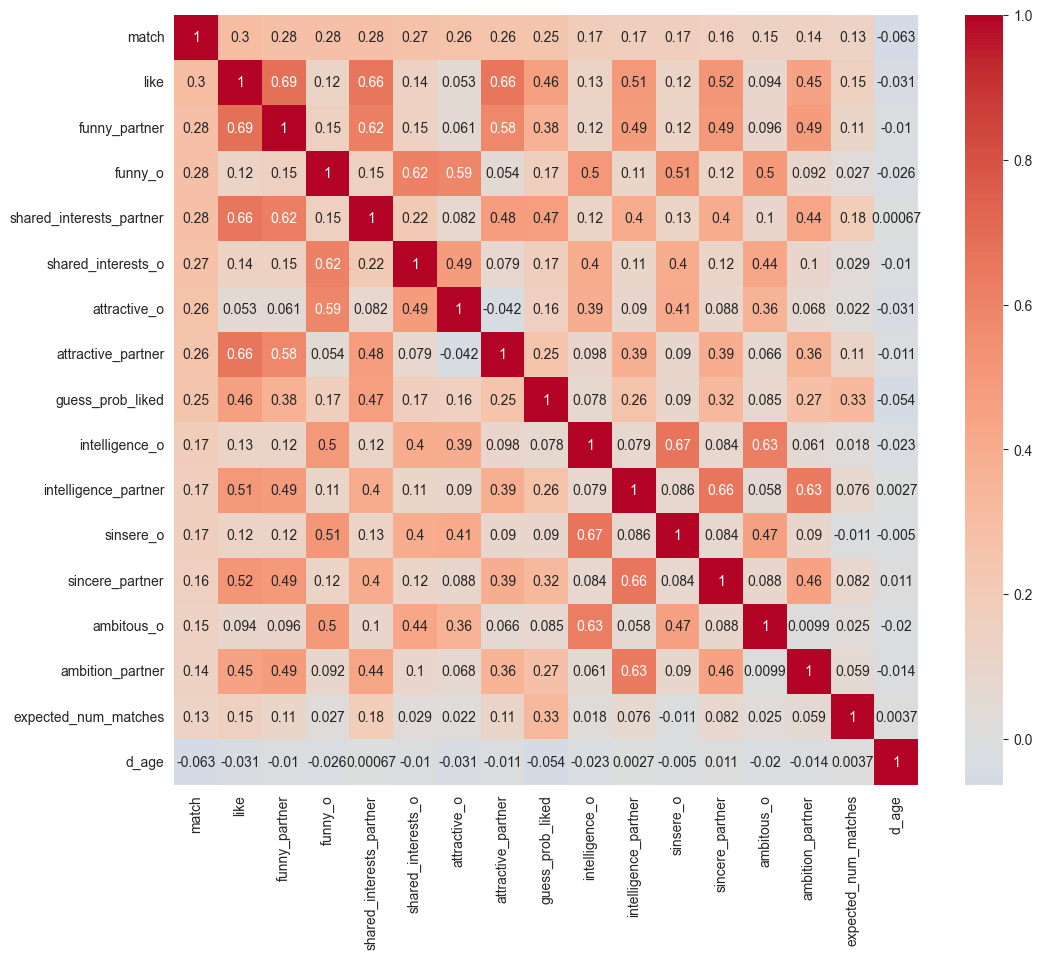

In [70]:
target_corr = df_clean.select_dtypes(include='number').corr()['match'].sort_values(ascending=False)
target_corr = target_corr.drop(["decision_o", "decision"], errors="ignore")
top_features = target_corr.abs().sort_values(ascending=False).head(17).index

plt.figure(figsize=(12,10))
sns.heatmap(df_clean[top_features].corr(), annot=True, cmap="coolwarm", center=0)
plt.show()

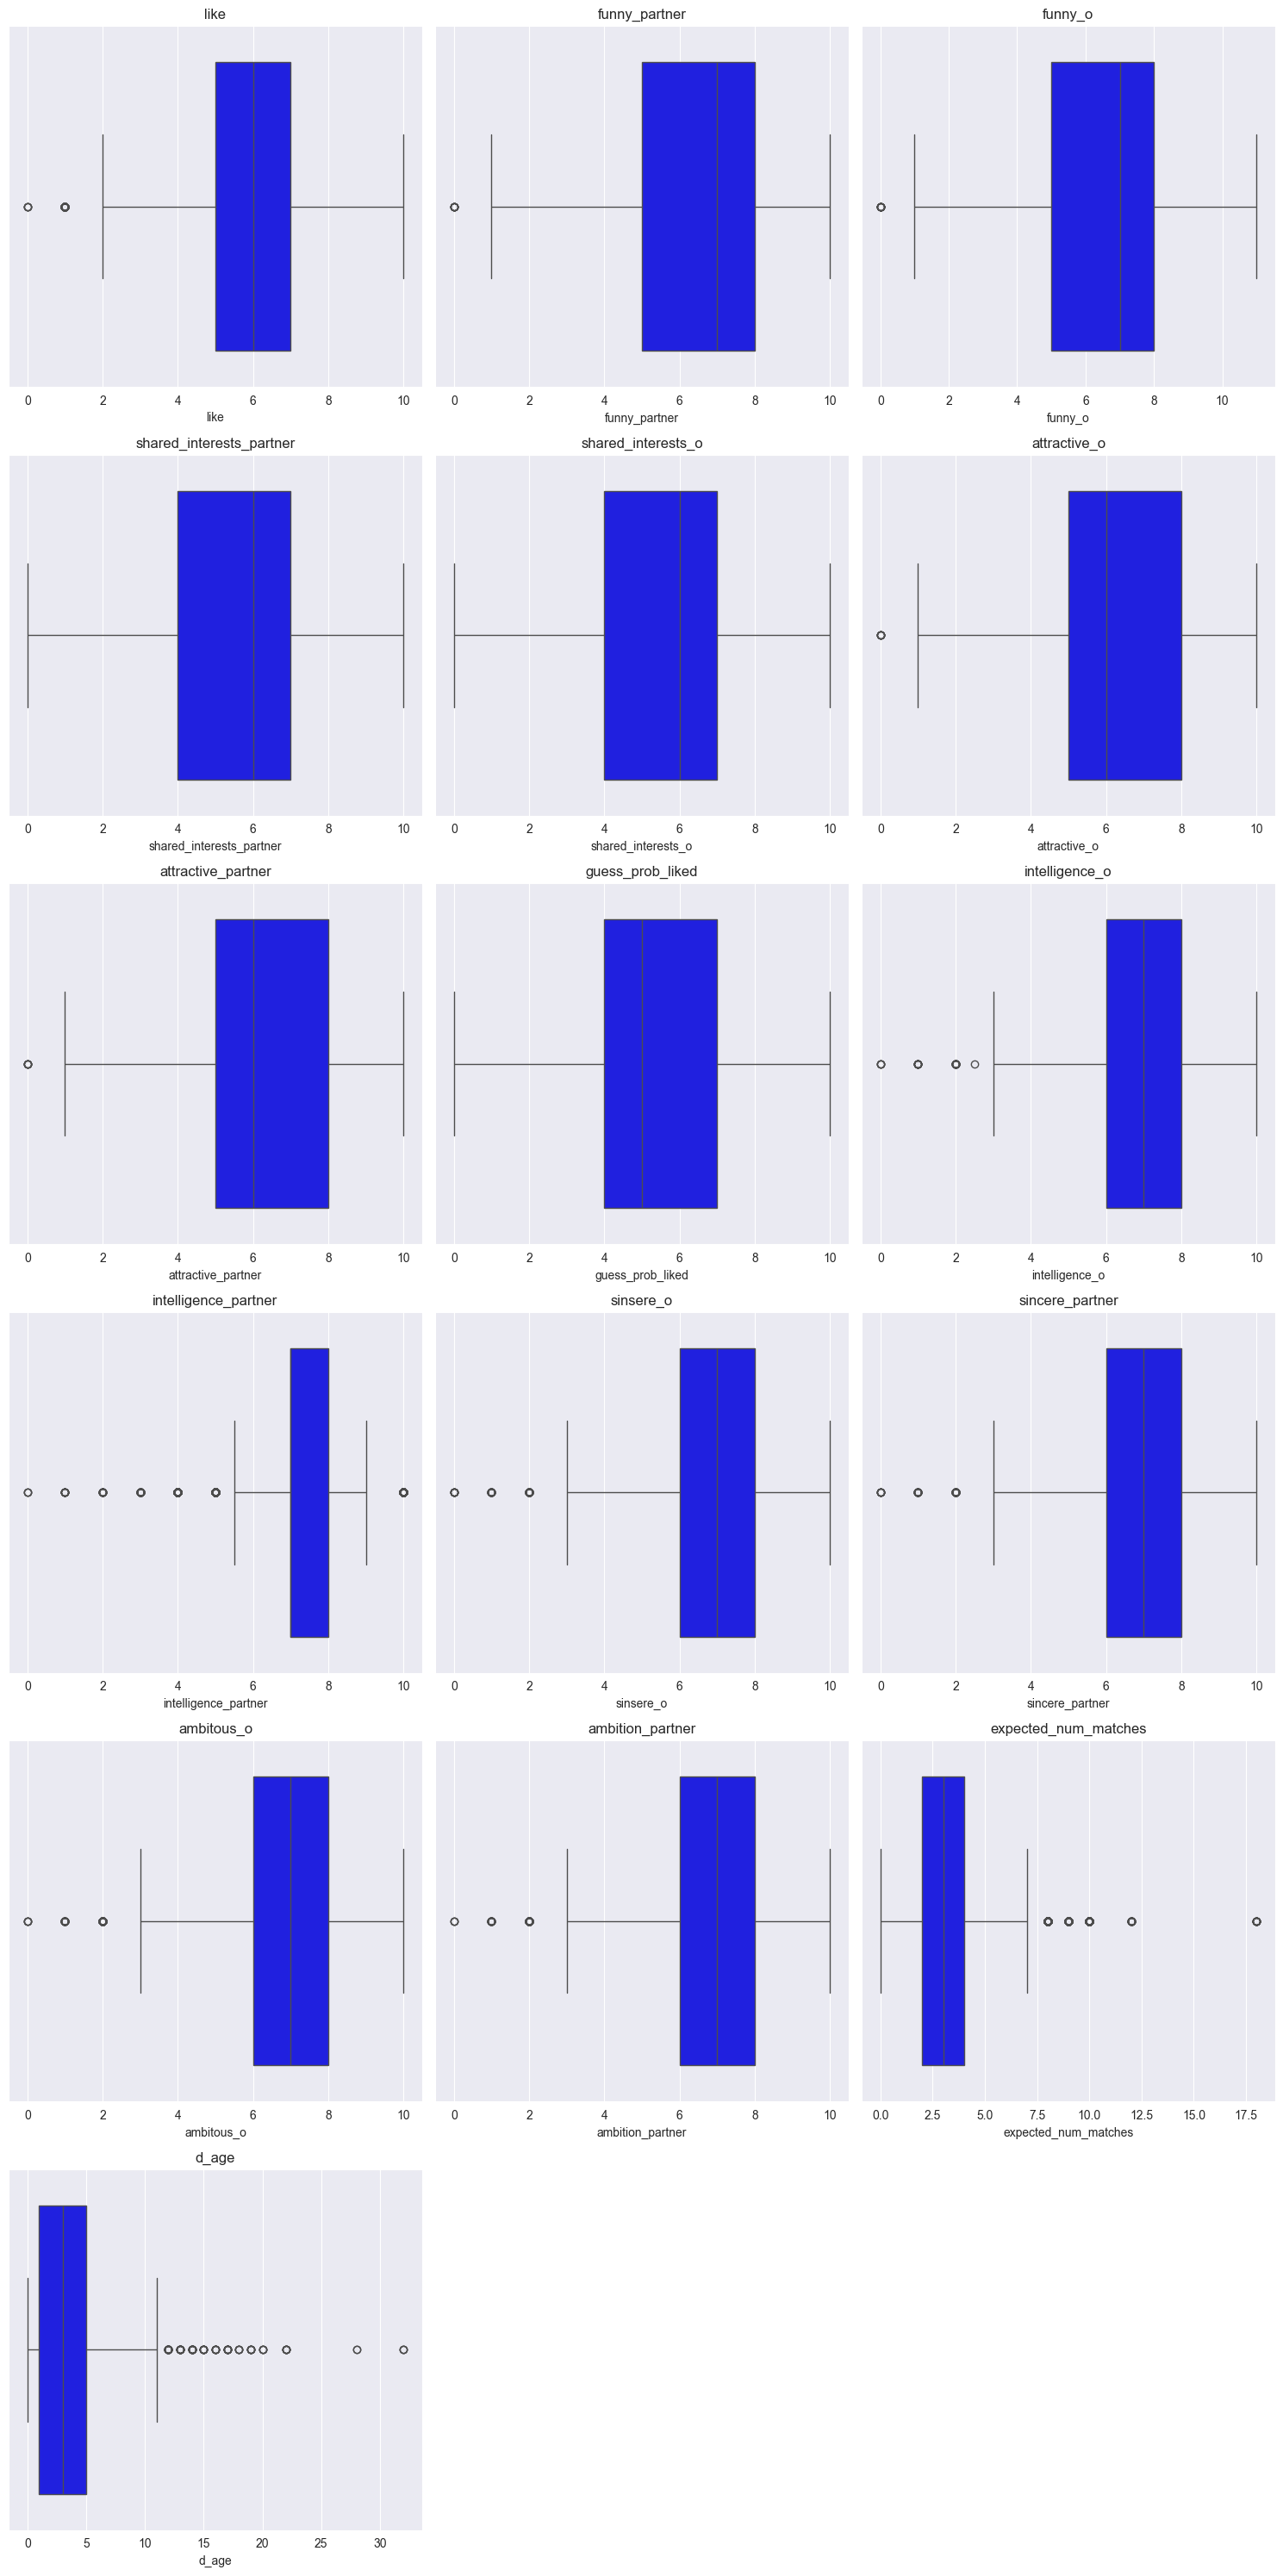

In [71]:
#Boxploty pre najviac korelujúce stĺpce, mimo tie čo majú binárnu hodnotu
cols = [c for c in top_features if df_clean[c].nunique() > 2]

n = len(cols)
rows = math.ceil(n / 3)
fig, axes = plt.subplots(rows, 3, figsize=(15, 5*rows))
axes = axes.flatten()
for ax, col in zip(axes, cols):
    sns.boxplot(x=df_clean[col], ax=ax, color="blue")
    ax.set_title(col)
for ax in axes[n:]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

### Nahradim missing values realnym cislo -> pouzijem KNN imputer

#### Pozrieme sa kolko sme mali missing_values


In [72]:
df_clean.isnull().sum()

gender                             0
age                                0
age_o                              0
d_age                              0
race                               0
                                ... 
expected_happy_with_sd_people     14
expected_num_matches             931
like                              90
guess_prob_liked                 145
match                              0
Length: 62, dtype: int64

In [73]:
attributes_to_fill = [
"expected_num_matches"
,"shared_interests_partner"
,"ambition_partner"
,"funny_partner"
,"guess_prob_liked"
,"intelligence_partner"
,"sincere_partner"
,"like"
,"attractive_partner"
,"pref_o_shared_interests"
,"shared_interests_important"
,"intelligence"
,"attractive"
,"ambition"
,"funny"
,"sincere"
,"interests_correlate"
,"pref_o_ambitious"
,"pref_o_funny"
,"funny_important"
,"ambtition_important"
,"pref_o_attractive"
,"pref_o_intelligence"
,"pref_o_sincere"
,"reading"
,"tv"
,"sincere_important"
,"importance_same_race"
,"attractive_important"
,"museums"
,"art"
,"intellicence_important"
,"importance_same_religion"
,"expected_happy_with_sd_people"
,"yoga"
,"clubbing"
,"gaming"
,"hiking"
,"theater"
,"concerts"
,"movies"
,"dining"
,"sports"
,"shopping"
,"music"
,"tvsports"
,"exercise"
]

In [74]:
df_clean[attributes_to_fill].dtypes

expected_num_matches             float64
shared_interests_partner         float64
ambition_partner                 float64
funny_partner                    float64
guess_prob_liked                 float64
intelligence_partner             float64
sincere_partner                  float64
like                             float64
attractive_partner               float64
pref_o_shared_interests          float64
shared_interests_important       float64
intelligence                     float64
attractive                       float64
ambition                         float64
funny                            float64
sincere                          float64
interests_correlate              float64
pref_o_ambitious                 float64
pref_o_funny                     float64
funny_important                  float64
ambtition_important              float64
pref_o_attractive                float64
pref_o_intelligence              float64
pref_o_sincere                   float64
reading         

#### Riešenie outlierov

In [75]:
def identify_outliers_z(df, hranica = 3):
    mean = df.mean()
    std = df.std()
    z_skore = (df-mean)/std
    return df[np.abs(z_skore) > hranica]

indexy_z = set()

print("Počet outlierov")
for col in df_clean.select_dtypes(include=[np.number]):
    outliers_z = identify_outliers_z(df_clean[col])
    if len(outliers_z)>0:
        print(f"{col}: {len(outliers_z)}")
        indexy_z.update(outliers_z.index)

Počet outlierov
age: 55
age_o: 44
d_age: 87
pref_o_attractive: 133
pref_o_sincere: 85
pref_o_intelligence: 123
pref_o_funny: 60
pref_o_ambitious: 21
attractive_o: 7
sinsere_o: 43
intelligence_o: 49
funny_o: 12
ambitous_o: 43
attractive_important: 138
sincere_important: 85
intellicence_important: 82
funny_important: 60
ambtition_important: 22
attractive: 18
sincere: 128
intelligence: 55
funny: 77
ambition: 82
attractive_partner: 6
sincere_partner: 39
intelligence_partner: 38
funny_partner: 8
ambition_partner: 36
dining: 62
museums: 13
gaming: 65
reading: 9
theater: 13
movies: 59
concerts: 13
music: 73
interests_correlate: 4
expected_num_matches: 48
like: 4


### Riesenie vychylenych hodnot pomocou Z-score


Počet outlierov podľa z-skóre (|z| > 3):
d_age: 223


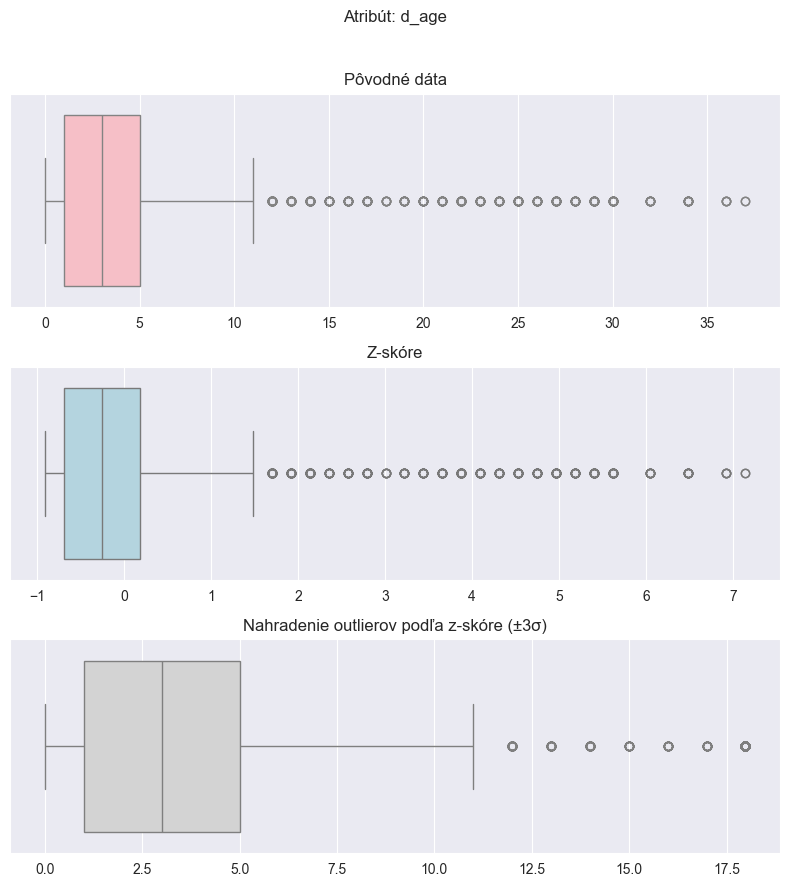

In [76]:
# to je pre z score
k = 3

#vybral som len tie ktoré majú aspoň 22 rôznych hodnôt
num_cols = df.select_dtypes(include='number').columns
columns_of_interest = [c for c in df_clean if df[c].nunique() > 22]

cols = [c for c in columns_of_interest if c in num_cols]
if not cols: 
    cols = list(num_cols)

means = df[cols].mean(skipna=True) #ignorujem nan hodnoty
stds  = df[cols].std(skipna=True) 
stds_safe = stds.replace(0, np.nan) #nechceme delit nulou tak radsej dame ako nan
z_df  = (df[cols] - means) / stds_safe
z_df  = z_df.replace([np.inf, -np.inf], np.nan)
lower = means - k * stds
upper = means + k * stds
df_wins = df.copy()
df_wins[cols] = df[cols].clip(lower=lower, upper=upper, axis=1)


print(f"\nPočet outlierov podľa z-skóre (|z| > {k}):")

pocet = (np.abs(z_df["d_age"]) > k).sum(skipna=True)
print(f"d_age: {pocet}")


fig, axes = plt.subplots(3, 1, figsize=(8, 9))
fig.suptitle("Atribút: d_age", y=0.98)
#povodne data
sns.boxplot(x=df["d_age"], ax=axes[0], color='lightpink')
axes[0].set_title("Pôvodné dáta")
axes[0].set_xlabel("")
 #z-score
sns.boxplot(x=z_df["d_age"], ax=axes[1], color='lightblue')
axes[1].set_title("Z-skóre")
axes[1].set_xlabel("")
#nahradim to podla z-score
sns.boxplot(x=df_wins["d_age"], ax=axes[2], color='lightgray')
axes[2].set_title(f"Nahradenie outlierov podľa z-skóre (±{k}σ)")
axes[2].set_xlabel("")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [77]:
print(columns_of_interest)

['age', 'age_o', 'd_age', 'field', 'pref_o_attractive', 'pref_o_sincere', 'pref_o_intelligence', 'pref_o_funny', 'pref_o_ambitious', 'pref_o_shared_interests', 'attractive_important', 'sincere_important', 'intellicence_important', 'funny_important', 'ambtition_important', 'shared_interests_important', 'interests_correlate']


Pred rozdelením dát ich musíme ešte:
- Náhodne premiešať (je vhodné si zvoliť random_state pre reprodukovateľnosť výsledkov)
- Stratifíkovať dáta podľa cieľovej premennej (match) - robí sa to vtedy keď je cieľová premenná nevyvážená (čo je náš prípad)
  - Chceme zabezpečiť, aby každá množina mala približne rovnaké zastúpenie každej kategórie


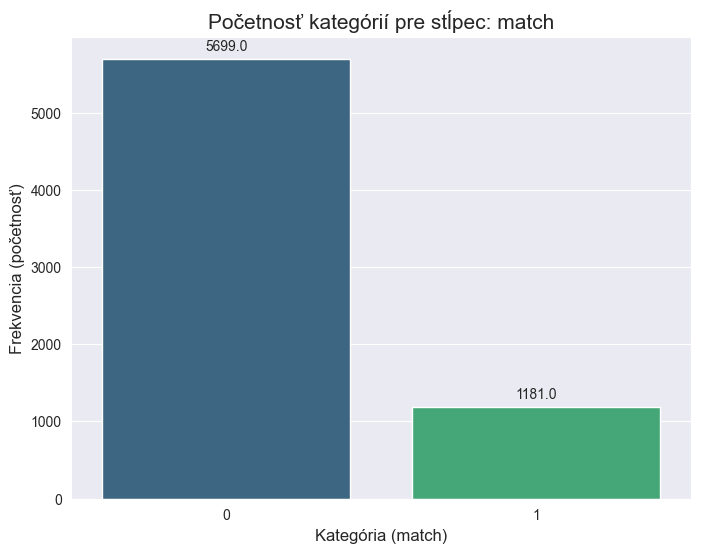

In [78]:
plt.figure(figsize=(8, 6))

# Funkcia sns.countplot automaticky vypočíta počet výskytov každej kategórie
ax = sns.countplot(x="match", data=df_clean, hue="match", legend=False, palette="viridis")

# Nastavenie popiskov a názvu
plt.title(f'Početnosť kategórií pre stĺpec: {"match"}', fontsize=15)
plt.xlabel(f'Kategória ({"match"})', fontsize=12)
plt.ylabel('Frekvencia (početnosť)', fontsize=12)

# Vloženie presných čísel (početnosti) nad každý stĺpec
for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')

plt.show()

# FEATURE SELECITON

In [79]:
# === PARAMETRE ===
TOP_K = 20
VOTE_THRESHOLD = 3
TARGET = "match"  # zmeň ak sa cieľ volá inak

# === IMPORTY ===
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import (
    VarianceThreshold, mutual_info_classif, SelectKBest, chi2, f_classif, RFE, SelectFromModel
)
from sklearn.linear_model import LogisticRegression

# === PRÍPRAVA Z df_clean (len numerické X) + IMPUTER NA NaN ===
y = df_clean[TARGET].to_numpy()
X_num = df_clean.drop(columns=[TARGET]).select_dtypes(include=[np.number])

imputer = SimpleImputer(strategy='median')
X_imp = pd.DataFrame(imputer.fit_transform(X_num), columns=X_num.columns, index=X_num.index)

feature_names = X_imp.columns.to_numpy()
df_all   = X_imp.copy()
df_std   = pd.DataFrame(StandardScaler().fit_transform(df_all), columns=feature_names, index=df_all.index)
df_nonneg= pd.DataFrame(MinMaxScaler().fit_transform(df_all),   columns=feature_names, index=df_all.index)
transform_cols = feature_names

# === 1) VARIANCE THRESHOLD ===
thresholds = np.arange(0, 1, 0.05)
dropped_at = {col: None for col in transform_cols}
for t in thresholds:
    vt = VarianceThreshold(threshold=t)
    vt.fit(df_all[transform_cols])
    kept = transform_cols[vt.get_support()]
    for col in transform_cols:
        if col not in kept and dropped_at[col] is None:
            dropped_at[col] = t
df_var = pd.DataFrame({'Feature': transform_cols, 'Dropped_at': [d if d is not None else 1.0 for d in dropped_at.values()]})
df_var['Rank'] = df_var['Dropped_at'].rank(method='dense', ascending=False).astype(int)
df_var = df_var.sort_values('Dropped_at', ascending=False).reset_index(drop=True)

# === 2) MUTUAL INFORMATION ===
mi = mutual_info_classif(df_all[transform_cols], y, discrete_features='auto', random_state=42)
df_mic = pd.DataFrame({'Feature': transform_cols, 'MI_Score': mi}).sort_values('MI_Score', ascending=False).reset_index(drop=True)
df_mic['Rank'] = df_mic['MI_Score'].rank(method='dense', ascending=False).astype(int)

# === 3) CHI-SQUARED (>=0 -> df_nonneg) ===
skb_chi = SelectKBest(score_func=chi2, k='all').fit(df_nonneg[transform_cols], y)
df_chi = pd.DataFrame({'Feature': transform_cols, 'Chi2_Score': skb_chi.scores_}).sort_values('Chi2_Score', ascending=False).reset_index(drop=True)
df_chi['Rank'] = df_chi['Chi2_Score'].rank(method='dense', ascending=False).astype(int)

# === 4) ANOVA (f_classif) ===
skb_f = SelectKBest(score_func=f_classif, k='all').fit(df_all[transform_cols], y)
df_f = pd.DataFrame({'Feature': transform_cols, 'F_Score': skb_f.scores_}).sort_values('F_Score', ascending=False).reset_index(drop=True)
df_f['Rank'] = df_f['F_Score'].rank(method='dense', ascending=False).astype(int)

# === 5) RFE (LogReg) na štandardizovaných dátach ===
features = list(transform_cols)
drop_order = []
X_tmp = df_std[features].copy()
est = LogisticRegression(max_iter=2000, random_state=45)
while len(features) > 1:
    rfe = RFE(estimator=est, n_features_to_select=len(features)-1, step=1)
    rfe.fit(X_tmp, y)
    eliminated = [f for f, keep in zip(features, rfe.support_) if not keep][0]
    drop_order.append(eliminated)
    features.remove(eliminated)
    X_tmp = X_tmp[features]
drop_order.append(features[0])
drop_order.reverse()
df_rfe = pd.DataFrame({'Feature': drop_order, 'Rank': range(1, len(drop_order)+1)})

# === 6) SelectFromModel (LogReg, |coef|) ===
est2 = LogisticRegression(max_iter=5000, random_state=45)
sfm = SelectFromModel(estimator=est2).fit(df_std[transform_cols], y)
importances = np.abs(sfm.estimator_.coef_[0])
df_sfm = pd.DataFrame({'Feature': transform_cols, 'Importance': importances}).sort_values('Importance', ascending=False).reset_index(drop=True)
df_sfm['Rank'] = df_sfm['Importance'].rank(method='dense', ascending=False).astype(int)

# === ZBER TOP_K A HLASOVANIE ===
def topk_names(df, score_col_or_rank, by_score_desc=True):
    if score_col_or_rank == 'Rank':
        return df.sort_values('Rank', ascending=True)['Feature'].head(TOP_K).tolist()
    return df.sort_values(score_col_or_rank, ascending=not by_score_desc)['Feature'].head(TOP_K).tolist()

tops = {
    'VAR': topk_names(df_var, 'Dropped_at', by_score_desc=True),
    'MI' : topk_names(df_mic, 'MI_Score', by_score_desc=True),
    'CHI': topk_names(df_chi, 'Chi2_Score', by_score_desc=True),
    'F'  : topk_names(df_f,   'F_Score', by_score_desc=True),
    'RFE': topk_names(df_rfe, 'Rank'),
    'SFM': topk_names(df_sfm, 'Importance', by_score_desc=True),
}

rank_maps = {
    'VAR': {f:i+1 for i,f in enumerate(df_var.sort_values('Dropped_at',  ascending=False)['Feature'])},
    'MI' : {f:i+1 for i,f in enumerate(df_mic.sort_values('MI_Score',   ascending=False)['Feature'])},
    'CHI': {f:i+1 for i,f in enumerate(df_chi.sort_values('Chi2_Score', ascending=False)['Feature'])},
    'F'  : {f:i+1 for i,f in enumerate(df_f.sort_values('F_Score',      ascending=False)['Feature'])},
    'RFE': {f:i+1 for i,f in enumerate(df_rfe.sort_values('Rank',       ascending=True )['Feature'])},
    'SFM': {f:i+1 for i,f in enumerate(df_sfm.sort_values('Importance', ascending=False)['Feature'])},
}

from collections import Counter, defaultdict
votes = Counter()
ranks = defaultdict(list)

for method, feat_list in tops.items():
    for f in feat_list:
        votes[f] += 1
        ranks[f].append(rank_maps[method][f])

final = []
for f, v in votes.items():
    if v >= VOTE_THRESHOLD:
        avg_r = np.mean(ranks[f])
        final.append((f, v, avg_r))

if not final:
    for f, v in votes.most_common(TOP_K):
        final.append((f, v, np.mean(ranks[f])))

final_df = pd.DataFrame(final, columns=['Feature','Votes','Avg_Rank']) \
           .sort_values(['Votes','Avg_Rank'], ascending=[False, True]) \
           .reset_index(drop=True)

SELECTED_FEATURES = final_df['Feature'].tolist()

# === JEDINÝ VÝSTUP + DÁTA PRE TVOJ MODEL (len najlepšie featury po imputácii) ===
print(f"=== FINÁLNE NAJLEPŠIE FEATURES (TOP_{TOP_K} v >= {VOTE_THRESHOLD} metódach) ===")
print(final_df.to_string(index=False))

X_fs = X_imp[SELECTED_FEATURES].to_numpy(dtype=np.float32)
y_fs = y.astype(np.float32)

print("\n=== PRIPRAVENÉ PRE MODEL ===")
print("SELECTED_FEATURES:", SELECTED_FEATURES)
print("X_fs shape:", X_fs.shape, " y_fs shape:", y_fs.shape)

SELECTED_FEATURES.append('race')
SELECTED_FEATURES.append('race_o')
SELECTED_FEATURES.append('gender')
SELECTED_FEATURES.append('field')


=== FINÁLNE NAJLEPŠIE FEATURES (TOP_20 v >= 3 metódach) ===
                 Feature  Votes  Avg_Rank
      shared_interests_o      6  5.166667
            attractive_o      6  5.166667
                 funny_o      6  6.333333
                    like      5  1.800000
           funny_partner      5  4.800000
      attractive_partner      5  5.800000
        guess_prob_liked      5  5.800000
shared_interests_partner      5  9.000000
        ambition_partner      5 11.800000
    expected_num_matches      5 12.400000
              ambitous_o      5 12.600000
                   d_age      5 13.800000
          intelligence_o      4 11.500000
               sinsere_o      4 11.750000
     pref_o_intelligence      4 12.500000
    intelligence_partner      3 11.333333
         sincere_partner      3 11.333333
            pref_o_funny      3 12.000000
    importance_same_race      3 13.000000
    attractive_important      3 16.000000
       sincere_important      3 18.333333

=== PRIPRAVENÉ 


Rozdelíme si dáta na 3 množiny:
- Trénovacia množina (70% dát) - na trénovanie modelu
- Validačná množina (15% dát) - na testovani správnosti modelu počas tréningu
- Testovacia množina (15% dát) - na finálne otestovanie modelu

Tento pomer môže byť aj iný ale 70/15/15 je bežný štandard.



In [80]:
from sklearn.model_selection import train_test_split

df_clean_fs = df_clean[SELECTED_FEATURES + [TARGET]].copy()


X_temp, X_test, y_temp, y_test = train_test_split(
    df_clean.drop(columns=['match']),
    df_clean['match'],
    test_size=0.15,
    random_state=69,
    stratify=df_clean['match']
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.1765,  # približne 15% z pôvodných dát
    random_state=69,
    stratify=y_temp
)

print(f"Tréningová množina: {X_train.shape[0]} vzoriek")
print(f"Validačná množina: {X_val.shape[0]} vzoriek")
print(f"Testovacia množina: {X_test.shape[0]} vzoriek")

Tréningová množina: 4815 vzoriek
Validačná množina: 1033 vzoriek
Testovacia množina: 1032 vzoriek


#### Feature Selection

---
###                                                                                                      PIPELINE
---

Aké také čistenie field, pred pipeline

In [81]:
class FieldCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, replacements=None):
        # replacment čo nás napadlo
        self.replacements = replacements or {
            'eng': 'engineering',
            'engineer': 'engineering',
            'computer science': 'cs',
            'comp sci': 'cs',
            'information technology': 'cs',
            'law school': 'law',
            'psych': 'psychology',
            'psychological': 'psychology',
            'biz': 'business',
            'econ': 'economics',
            'bio': 'biology',
            'bioinformatics': 'biology',
            'edu': 'education',
            'teacher': 'education',
            'med': 'medicine',
            'pre med': 'medicine',
            'art history': 'arts',
            'art': 'arts'
        }

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        col = X.columns[0]
        s = X[col].astype(str).str.lower().str.strip()
        s = s.apply(lambda x: re.sub(r'[^a-z\s]', '', x))

        def normalize(x):
            for k, v in self.replacements.items():
                if k in x:
                    return v
            return x

        s = s.apply(normalize)

        s = s.replace(['nan', 'none', 'unknown', '', ' '], np.nan)
        s = s.fillna('missing')

        X[col] = s
        return X

### Vytvorili sme PipeLine, kde sme data najprv zmenili všetky kategorické dáta na numerické a potom sme dáta vyscalovali.

In [82]:
gender_races_cols = ['race','race_o','gender']
num_cols = X_train.select_dtypes(include=['number']).columns.tolist()
field_cols = ['field']

numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

race_gender_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

field_transformer = Pipeline(steps=[
    ('clean', FieldCleaner()),
    ('target', TargetEncoder(
        cols=['field'],
        smoothing=50.0,
        handle_missing='value',
        handle_unknown='value'
    )),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('gen_race', race_gender_transformer, gender_races_cols),
        ('field', field_transformer, field_cols)
    ],
    remainder='drop'
)

final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
])

final_pipeline.fit(X_train, y_train)

n_features = preprocessor.transform(X_train[:5]).shape[1]

In [83]:
import wandb
from skorch.callbacks import WandbLogger
wandb.login()

True

In [84]:
# 1. Fitneme preprocessor (TargetEncoder potrebuje X aj y)
preprocessor.fit(X_train, y_train)

# 2. Transformujeme všetky množiny
X_train_prep = preprocessor.transform(X_train).astype(np.float32)
X_val_prep = preprocessor.transform(X_val).astype(np.float32)
X_test_prep = preprocessor.transform(X_test).astype(np.float32)

# 3. Cieľová premenná (y) už je pripravená
y_train_float = y_train.to_numpy().astype(np.float32)
y_val_float = y_val.to_numpy().astype(np.float32)
y_test_float = y_test.to_numpy().astype(np.float32)

# 4. Získame finálny počet príznakov
n_features = X_train_prep.shape[1]
print(f"Počet príznakov na vstupe do modelu: {n_features}")

# 5. Pripravíme validačný dataset pre skorch - TOTO UŽ NEPOTREBUJEME
# from skorch.dataset import Dataset, predefined
# valid_dataset = Dataset(X=X_val_prep, y=y_val_float)

Počet príznakov na vstupe do modelu: 70


In [85]:
import torch.nn as nn
import torch.nn.functional as F

class MLPModule(nn.Module):
    def __init__(self,
                 input_features,
                 hidden_layers,
                 dropout_rate=0.5,
                 use_batch_norm=True,
                 activation_fn=nn.ReLU): # <-- Nový parameter

        super(MLPModule, self).__init__()

        layers = []
        in_feats = input_features

        for h_feats in hidden_layers:
            layers.append(nn.Linear(in_feats, h_feats))

            # === Pridané Batch Norm ===
            if use_batch_norm:
                layers.append(nn.BatchNorm1d(h_feats))
            # ==========================

            layers.append(activation_fn()) # <-- Použitie flexibilnej aktivácie
            layers.append(nn.Dropout(dropout_rate))
            in_feats = h_feats

        layers.append(nn.Linear(in_feats, 1))
        self.network = nn.Sequential(*layers)

    def forward(self, X, **kwargs):
        X = X.float()
        return self.network(X).squeeze(-1)

In [86]:
import numpy as np # Predpokladám, že je už importovaný
import torch # Predpokladám, že je už importovaný
import wandb # Predpokladám, že je už importovaný
from skorch.callbacks import EarlyStopping, EpochScoring
from skorch.helper import predefined_split
# PRIDANÉ: confusion_matrix a classification_report
from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix, classification_report
import time

# --- Tu si definujte svoje experimenty ---
experiments = [
    {
        'name': 'exp_pos_w_2',
        'lr': 0.0008,
        'max_epochs': 60,
        'batch_size': 1024,
        'optimizer': torch.optim.Adam,
        'module__hidden_layers': [512, 256, 128],
        'module__dropout_rate': 0.3,
        'pos_weight': 2.0
    },
    {
        'name': 'exp_pos_w_2.5',
        'lr': 0.0008,
        'max_epochs': 60,
        'batch_size': 1024,
        'optimizer': torch.optim.Adam,
        'module__hidden_layers': [512, 256, 128],
        'module__dropout_rate': 0.3,
        'pos_weight': 2.5
    },
    {
        'name': 'exp_pos_w_3',
        'lr': 0.0008,
        'max_epochs': 60,
        'batch_size': 1024,
        'optimizer': torch.optim.Adam,
        'module__hidden_layers': [512, 256, 128],
        'module__dropout_rate': 0.3,
        'pos_weight': 3
    },
    '''
    {
        'name': 'Maly_model_rychly_LR',
        'lr': 0.005,
        'max_epochs': 50,
        'batch_size': 256,
        'optimizer': torch.optim.Adam,
        'module__hidden_layers': [64, 32],
        'module__dropout_rate': 0.2,

    },
    {
        'name': 'Vacsi_model_pomaly_LR_RMSprop',
        'lr': 0.0005,
        'max_epochs': 150,
        'batch_size': 512,
        'optimizer': torch.optim.RMSprop,
        'module__hidden_layers': [256, 128, 64],
        'module__dropout_rate': 0.4,
    },
    {
        'name': 'Hlboky_model_vysoky_dropout',
        'lr': 0.001,
        'max_epochs': 150,
        'batch_size': 256,
        'optimizer': torch.optim.Adam,
        'module__hidden_layers': [512, 256, 128, 64],
        'module__dropout_rate': 0.6,
    },
    {
        'name': 'Hlboky_model_vysoky_dropout',
        'lr': 0.01,
        'max_epochs': 500,
        'batch_size': 512,
        'optimizer': torch.optim.Adam,
        'module__hidden_layers': [512, 256, 128, 64],
        'module__dropout_rate': 0.2,
    },
    {
        'name': 'Test_5_F1_0.576',
        'lr': 0.001,
        'max_epochs': 80,
        'batch_size': 512,
        'optimizer': torch.optim.Adam,
        'module__hidden_layers': [256, 128],
        'module__dropout_rate': 0.2,
    },
    {
        'name': 'Test_5_F1_0.571',
        'lr': 0.002,
        'max_epochs': 60,
        'batch_size': 1024,
        'optimizer': torch.optim.Adam,
        'module__hidden_layers': [640, 320, 160],
        'module__dropout_rate': 0.3,
    },

    {
        'name': 'Test_9_F1_0.577',
        'lr': 0.001,
        'max_epochs': 60,
        'batch_size': 1024,
        'optimizer': torch.optim.Adam,
        'module__hidden_layers': [512, 256],
        'module__dropout_rate': 0.4,
    },

    {
        'name': 'Test_26_F1_0.573',
        'lr': 0.0006,
        'max_epochs': 60,
        'batch_size': 512,
        'optimizer': torch.optim.Adam,
        'module__hidden_layers': [640, 320, 160],
        'module__dropout_rate': 0.3,
    },
    '''
]

from skorch.dataset import Dataset
valid_ds = Dataset(X_val_prep, y_val_float)

# Predpokladáme, že y_train_float je váš NumPy rad s hodnotami 0.0 a 1.0
count_0 = np.sum(y_train_float == 0)
count_1 = np.sum(y_train_float == 1)

# Výpočet váhy pre pozitívnu triedu
pos_weight_value = count_0 / count_1

print(f"Počet vzoriek 0: {count_0}")
print(f"Počet vzoriek 1: {count_1}")
print(f"Vypočítaná váha 'pos_weight': {pos_weight_value:.4f}")

# Skorch potrebuje, aby to bol torch.Tensor
# Presunieme ho na správne zariadenie (device), hoci skorch by to mal zvládnuť
# Uistime sa, že je to float32, rovnako ako vaše dáta
pos_weight_tensor = torch.tensor([pos_weight_value], dtype=torch.float32)

# --- Trénovací Loop ---
for i, exp_params in enumerate(experiments):

    start_time = time.time()
    print(f"\n--- Spúšťam experiment {i+1}/{len(experiments)}: {exp_params['name']} ---")

    # 1. Inicializácia W&B pre TENTO beh
    run = wandb.init(
        project="SpeedDating-MLP",
        name=exp_params['name'],
        config=exp_params
    )

    # 2. Vytvorenie Callbackov pre tento beh
    callbacks = [
        # F1 počas validácie
        ('val_f1', EpochScoring(
            scoring='f1',
            lower_is_better=False,
            on_train=False,
            name='val_f1'
        )),
        # Early stopping bude sledovať práve túto metriku
        ('early_stop', EarlyStopping(
            monitor='val_f1',
            patience=10,
            lower_is_better=False
        )),
        # Wandb logger
        ('wandb_logger', WandbLogger(wandb_run=run))
    ]

    # 3. Vytvorenie inštancie modelu
    torch.manual_seed(69)
    net = NeuralNetBinaryClassifier(
        module=MLPModule,
        module__input_features=n_features,
        criterion=torch.nn.BCEWithLogitsLoss,
        criterion__pos_weight=pos_weight_tensor,
        # Skorch má rád validáciu cez predefined_split
        train_split=predefined_split(valid_ds),  # definuj nižšie

        verbose=0,
        callbacks=callbacks,
        **{k: v for k, v in exp_params.items() if k != 'name'}
    )

    # 4. Trénovanie
    net.fit(X_train_prep, y_train_float)

    # 5. Vyhodnotenie na Testovacej množine
    y_pred_test = net.predict(X_test_prep)
    y_proba_test = net.predict_proba(X_test_prep)[:, 1]

    test_f1 = f1_score(y_test, y_pred_test)
    test_logloss = log_loss(y_test, y_proba_test)
    test_accuracy = accuracy_score(y_test, y_pred_test)

    # PRIDANÉ: Výpočet confusion matrix a reportu
    test_cm = confusion_matrix(y_test, y_pred_test)
    test_report = classification_report(y_test, y_pred_test)

    print(f"Test F1: {test_f1:.4f} | Test LogLoss: {test_logloss:.4f} | Test Acc: {test_accuracy:.4f}")

    # PRIDANÉ: Výpis confusion matrix a reportu
    print(f"Test Confusion Matrix:\n{test_cm}")
    print(f"Test Classification Report:\n{test_report}")


    # 6. Manuálne logovanie finálnych (testovacích) metrík do W&B
    wandb.log({
        "test_f1": test_f1,
        "test_logloss": test_logloss,
        "test_accuracy": test_accuracy,
        "training_time_s": time.time() - start_time,
        "best_epoch": net.history_[-1, 'epoch']
    })

    # 7. Ukončenie W&B behu
    run.finish()

print("\n--- Všetky experimenty dokončené ---")

Počet vzoriek 0: 3988
Počet vzoriek 1: 827
Vypočítaná váha 'pos_weight': 4.8222

--- Spúšťam experiment 1/9: Maly_model_rychly_LR ---


Test F1: 0.5370 | Test LogLoss: 0.5216 | Test Acc: 0.8062
Test Confusion Matrix:
[[716 139]
 [ 61 116]]
Test Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.84      0.88       855
           1       0.45      0.66      0.54       177

    accuracy                           0.81      1032
   macro avg       0.69      0.75      0.71      1032
weighted avg       0.84      0.81      0.82      1032



best_epoch,▁
dur,▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,▁
test_f1,▁
test_logloss,▁
train_loss,█▆▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁
training_time_s,▁
val_f1,▁▁▄▂▄▇▂▆▄▃▃▃▂▅▂█▂▅▆▄▇▂▆▇▄
valid_acc,▁▂▄▄▅▅▄▅▆▅▅▅▅▆▆▇▅▆▇▆█▆▇▇▇
valid_loss,▁▁▁▁▁▂▂▂▃▃▃▄▄▅▄▅▄▅▆▆▇▆▇██
best_epoch,26



--- Spúšťam experiment 2/9: Vacsi_model_pomaly_LR_RMSprop ---


Test F1: 0.5472 | Test LogLoss: 0.4515 | Test Acc: 0.7771
Test Confusion Matrix:
[[663 192]
 [ 38 139]]
Test Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.78      0.85       855
           1       0.42      0.79      0.55       177

    accuracy                           0.78      1032
   macro avg       0.68      0.78      0.70      1032
weighted avg       0.86      0.78      0.80      1032



best_epoch,▁
dur,▁▁▅▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁
test_accuracy,▁
test_f1,▁
test_logloss,▁
train_loss,█▆▅▄▄▄▄▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
training_time_s,▁
val_f1,▁▃▃▅▄▄▆▅▆▅▆▇▅▅▅▆▆▆▆▇▇██▇██▆▆▇▇▇
valid_acc,▁▃▃▅▄▄▆▆▆▅▆▇▆▅▆▆▆▆▆▇▇█▇▇▇█▇▆▇█▇
valid_loss,█▄▂▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▅▄▄▅▅▆▆▆
best_epoch,32



--- Spúšťam experiment 3/9: Hlboky_model_vysoky_dropout ---


Test F1: 0.5426 | Test LogLoss: 0.4501 | Test Acc: 0.7713
Test Confusion Matrix:
[[656 199]
 [ 37 140]]
Test Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.77      0.85       855
           1       0.41      0.79      0.54       177

    accuracy                           0.77      1032
   macro avg       0.68      0.78      0.70      1032
weighted avg       0.86      0.77      0.80      1032



best_epoch,▁
dur,▁▁▁▁▁▁▁▁▁▁█▂▁▁▁▁▁▁▁▁▁▁▁▁▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,▁
test_f1,▁
test_logloss,▁
train_loss,█▇▆▅▅▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
training_time_s,▁
val_f1,▃▁▂▃▄▄▄▃▃▃▄▄▅▄▄▄▅▄▅▅▆▆▄▄▅▆▆▄▄▆▆█▆▆▆▆▅▅▆▆
valid_acc,▇▁▂▃▄▅▄▄▄▄▅▅▅▅▅▅▆▅▅▅▇▆▆▅▆▆▆▅▅▇▇█▆▇▇▇▆▆▇▇
valid_loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▅▇
best_epoch,42



--- Spúšťam experiment 4/9: Hlboky_model_vysoky_dropout ---


Test F1: 0.5000 | Test LogLoss: 0.8424 | Test Acc: 0.8178
Test Confusion Matrix:
[[750 105]
 [ 83  94]]
Test Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       855
           1       0.47      0.53      0.50       177

    accuracy                           0.82      1032
   macro avg       0.69      0.70      0.69      1032
weighted avg       0.83      0.82      0.82      1032



best_epoch,▁
dur,▂▁▁▁▁▁▁▁▁▁▁█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,▁
test_f1,▁
test_logloss,▁
train_loss,█▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁
training_time_s,▁
val_f1,▃▃▅▄▅▅▂▄▅▄▅▆▃▄▄▆▅▅▇▆▅▅▄▁█▆▄▅▅▆▇▂█▆▆▃▆▃▄▅
valid_acc,▁▁▄▅▄▄▄▅▆▆▄▇▇▇▆▇▇█▇▇▇▆▇▆▇▇█▇▇█▇▇█▇██▇▇▇▇
valid_loss,▂▁▁▂▂▂▂▃▃▄▃▃▄▄▄▅▅▆▅▅▆▅▆▆▅▅▇▆▆▆▆█▇▆▇█▆▇▆▇
best_epoch,47



--- Spúšťam experiment 5/9: Test_1_F1_0.570 ---


Test F1: 0.5514 | Test LogLoss: 0.4574 | Test Acc: 0.7888
Test Confusion Matrix:
[[680 175]
 [ 43 134]]
Test Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.80      0.86       855
           1       0.43      0.76      0.55       177

    accuracy                           0.79      1032
   macro avg       0.69      0.78      0.71      1032
weighted avg       0.85      0.79      0.81      1032



best_epoch,▁
dur,▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁
test_accuracy,▁
test_f1,▁
test_logloss,▁
train_loss,█▆▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
training_time_s,▁
val_f1,▁▂▃▃▄▄▆▆▇▇▇▇█▇▇▇▇▇▇▇▆▆
valid_acc,▁▃▄▅▅▆▆▇▇▇▇▇██▇██▇████
valid_loss,█▅▃▃▂▁▁▁▁▁▁▁▂▂▂▂▃▃▄▅▅▅
best_epoch,23



--- Spúšťam experiment 6/9: Test_5_F1_0.576 ---


Test F1: 0.5526 | Test LogLoss: 0.4768 | Test Acc: 0.8227
Test Confusion Matrix:
[[736 119]
 [ 64 113]]
Test Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.86      0.89       855
           1       0.49      0.64      0.55       177

    accuracy                           0.82      1032
   macro avg       0.70      0.75      0.72      1032
weighted avg       0.85      0.82      0.83      1032



best_epoch,▁
dur,▁▁▁▁▁▁▁▁▁▁▇█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,▁
test_f1,▁
test_logloss,▁
train_loss,█▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
training_time_s,▁
val_f1,▁▃▄▄▅▆▆▆▆▆▇▆██▆█▇▆█▆▅▇█▇▆▆▇▇▇▇▅▅
valid_acc,▁▄▅▄▅▆▆▆▆▆▆▇▇▇▇▇▇▇█▇▇██▇▇███████
valid_loss,▃▂▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▆▆▆▇▇██
best_epoch,33



--- Spúšťam experiment 7/9: Test_5_F1_0.571 ---


Test F1: 0.5299 | Test LogLoss: 0.5373 | Test Acc: 0.8401
Test Confusion Matrix:
[[774  81]
 [ 84  93]]
Test Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.90       855
           1       0.53      0.53      0.53       177

    accuracy                           0.84      1032
   macro avg       0.72      0.72      0.72      1032
weighted avg       0.84      0.84      0.84      1032



best_epoch,▁
dur,▄▆▆▅▇▅▆▄▃▇▅▅▃▂▁▄▂▂▅▃▂▂▂▂▁▁▂▂▃▄█▅
test_accuracy,▁
test_f1,▁
test_logloss,▁
train_loss,█▆▆▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
training_time_s,▁
val_f1,▁▂▂▅▆▅▆▄▅▅▆▆▅█▇▇▆▆▆▅▅▆█▅▅▆▄▅▇▆▇▇
valid_acc,▁▂▂▃▄▄▅▅▅▅▆▆▆▇▇▇▇▆▇▆▆▇▇█▇▇▇▇█▇██
valid_loss,▂▂▁▁▁▁▁▁▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▇▆▆▇▇▆▆▇█
best_epoch,33



--- Spúšťam experiment 8/9: Test_9_F1_0.577 ---


Test F1: 0.5483 | Test LogLoss: 0.4591 | Test Acc: 0.8052
Test Confusion Matrix:
[[709 146]
 [ 55 122]]
Test Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.83      0.88       855
           1       0.46      0.69      0.55       177

    accuracy                           0.81      1032
   macro avg       0.69      0.76      0.71      1032
weighted avg       0.85      0.81      0.82      1032



best_epoch,▁
dur,▆▄▆▆█▆▅▄▄▄▅▇▇▅▅▆▆▄▅▆▅▅▄▄▅▄▁▂▃▂▃▃▂▃▁▂▅▅▂▄
test_accuracy,▁
test_f1,▁
test_logloss,▁
train_loss,█▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
training_time_s,▁
val_f1,▁▁▃▂▂▂▃▃▄▄▃▄▅▇▆▇▆▆▆▆▇▆▆▆█▆▇██▇▇█▇█▆▆▇▇▇▇
valid_acc,▁▃▄▄▃▃▄▅▅▅▄▅▅▆▆▇▆▆▆▇▇▇▆▇█▇▇▇█▇██████████
valid_loss,▄▃▂▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▆▆▆▇▆▆▆█
best_epoch,44



--- Spúšťam experiment 9/9: Test_26_F1_0.573 ---


Test F1: 0.5365 | Test LogLoss: 0.4830 | Test Acc: 0.8091
Test Confusion Matrix:
[[721 134]
 [ 63 114]]
Test Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.84      0.88       855
           1       0.46      0.64      0.54       177

    accuracy                           0.81      1032
   macro avg       0.69      0.74      0.71      1032
weighted avg       0.84      0.81      0.82      1032



best_epoch,▁
dur,▆▄▆▅▅▅▅▅▆▆▇▅▄▅▆▆█▆█▅▅▇▇▅▅▂▃▁▁
test_accuracy,▁
test_f1,▁
test_logloss,▁
train_loss,█▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
training_time_s,▁
val_f1,▁▃▃▄▃▄▄▆▆▅▆▇▇▆▇▇█▅▆█▅▄▆▇▆▇▇▆▆
valid_acc,▁▃▄▄▄▄▅▅▆▆▆▆▆▆▇▆▇▇▇▇▇▆▇█▇██▇█
valid_loss,▄▂▁▁▁▁▁▁▁▂▂▂▂▂▃▃▄▄▄▄▅▅▅▇▆▇███
best_epoch,30



--- Všetky experimenty dokončené ---


## Hyperparameter Search

In [87]:
# Pre skorch je potrebné, aby cieľová premenná (y) bola typu float32
y_train_float = y_train.to_numpy().astype(np.float32)
y_val_float = y_val.to_numpy().astype(np.float32)
y_test_float = y_test.to_numpy().astype(np.float32)

# Počet vstupných príznakov po transformácii (už máte vypočítané)
# n_features = 74 (alebo koľko vám vyšlo v bunke 27)
print(f"Počet príznakov na vstupe do modelu: {n_features}")

# Pre reprodukovateľnosť (keďže ste použili random_state=69)
torch.manual_seed(69)

Počet príznakov na vstupe do modelu: 70


In [88]:
import torch.nn as nn
import torch.nn.functional as F

class MLPModule(nn.Module):
    def __init__(self,
                 input_features,
                 hidden_layers,
                 dropout_rate=0.5,
                 use_batch_norm=True,     # <--- NOVÝ PARAMETER
                 activation_fn=nn.ReLU):  # <--- NOVÝ PARAMETER

        super(MLPModule, self).__init__()

        layers = []
        in_feats = input_features

        for h_feats in hidden_layers:
            layers.append(nn.Linear(in_feats, h_feats))

            # === Pridané Batch Norm ===
            if use_batch_norm:
                layers.append(nn.BatchNorm1d(h_feats))
            # ==========================

            layers.append(activation_fn()) # <--- Použitie flexibilnej aktivácie
            layers.append(nn.Dropout(dropout_rate))
            in_feats = h_feats

        layers.append(nn.Linear(in_feats, 1))
        self.network = nn.Sequential(*layers)

    def forward(self, X, **kwargs):
        X = X.float()
        return self.network(X).squeeze(-1)

In [89]:
from sklearn.model_selection import StratifiedKFold
from skorch.callbacks import EarlyStopping, EpochScoring
from skorch.dataset import ValidSplit
import torch
import torch.nn as nn # <-- Dôležitý import pre aktivačné funkcie

# --- KÓD PRE VÝPOČET VÁHY TRIED (zostáva) ---
counts = y_train.value_counts()
n_negative = counts[0]
n_positive = counts[1]
pos_weight_value = n_negative / n_positive
print(f"Vypočítaná váha (pos_weight): {pos_weight_value:.4f}")
pos_weight_tensor = torch.tensor([pos_weight_value], dtype=torch.float32)
# --- KONIEC KÓDU PRE VÝPOČET ---

# 1. Definícia skorch wrappera (zostáva)
net = NeuralNetBinaryClassifier(
    module=MLPModule,
    module__input_features=n_features,
    criterion=torch.nn.BCEWithLogitsLoss,
    train_split=ValidSplit(cv=0.2, stratified=True, random_state=69),
    verbose=0,
    callbacks=[
        ('f1_val', EpochScoring(scoring='f1', lower_is_better=False, on_train=False, name='val_f1')),
        ('early_stop', EarlyStopping(monitor='val_f1', patience=10, lower_is_better=False))
    ]
)

# 2. Vytvorenie kompletnej Pipeline (zostáva)
# Predpokladám, že teraz používate štandardnú Pipeline, keďže ste odstránili 'smote'
from sklearn.pipeline import Pipeline
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', net)
])

# 3. ParamGrid pre GridSearchCV (UPRAVENÝ)
param_grid = {
    'clf__lr': [1e-3, 5e-4],
    'clf__module__hidden_layers': [[128, 64], [256, 128, 64]],
    'clf__module__dropout_rate': [0.2, 0.5],
    'clf__batch_size': [256, 512],
    'clf__optimizer': [torch.optim.Adam, torch.optim.RMSprop],
    'clf__max_epochs': [100],
    'clf__criterion__pos_weight': [None, pos_weight_tensor],
    # L2 Regularizácia (Weight Decay)
    'clf__optimizer__weight_decay': [1e-4, 1e-5, 0],
    # Zapnutie/vypnutie Batch Normalizácie
    'clf__module__use_batch_norm': [True, False],
    # Rôzne aktivačné funkcie
    'clf__module__activation_fn': [nn.ReLU, nn.LeakyReLU, nn.GELU]
}

# 4. Definícia GridSearchCV (zostáva)
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=69)

gs = GridSearchCV(
    pipe,
    param_grid=param_grid,
    cv=skf,
    scoring='f1',
    n_jobs=-1,
    refit=True,
    verbose=2
)

Vypočítaná váha (pos_weight): 4.8222


In [ ]:
# Spustenie trénovania (môže to trvať dlhšie)
gs.fit(X_train, y_train_float)

print("Trénovanie dokončené.")

Fitting 3 folds for each of 1152 candidates, totalling 3456 fits


In [286]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, log_loss

# Získanie najlepšieho modelu z GridSearchCV
best_model = gs.best_estimator_

print("--- 1. Hľadanie optimálneho prahu na Validačných dátach ---")

# Získanie pravdepodobností pre validačné dáta
# (X_val a y_val boli definované v bunke 169)
y_proba_val = best_model.predict_proba(X_val)[:, 1]
y_true_val = y_val

# Otestujeme prahy od 0.1 do 0.9
thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = [f1_score(y_true_val, (y_proba_val >= t).astype(int)) for t in thresholds]

# Nájdenie najlepšieho prahu
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
best_f1_score_val = f1_scores[optimal_idx]

# Pôvodné F1 (z bunky 189)
original_f1_val = f1_score(y_val, best_model.predict(X_val))

print(f"Pôvodný F1 (prah 0.5): {original_f1_val:.4f}")
print(f"Optimálny F1 (prah {optimal_threshold:.2f}): {best_f1_score_val:.4f}")


print("\n--- 2. Aplikácia optimálneho prahu na Testovacích dátach ---")

# Získanie pravdepodobností pre testovacie dáta
# (X_test a y_test boli definované v bunke 169)
y_proba_test = best_model.predict_proba(X_test)[:, 1]
y_true_test = y_test

# --- Metriky s Pôvodným prahom (0.5) ---
y_pred_test_orig = best_model.predict(X_test)
f1_test_orig = f1_score(y_true_test, y_pred_test_orig)
acc_test_orig = accuracy_score(y_true_test, y_pred_test_orig)
ll_test = log_loss(y_true_test, y_proba_test) # LogLoss nezávisí od prahu

print(f"\nModel s prahom 0.5 (predvolený):")
print(f"  F1 skóre: {f1_test_orig:.4f}")
print(f"  Presnosť: {acc_test_orig:.4f}")
print(f"  LogLoss:  {ll_test:.4f}")

# --- Metriky s Optimálnym prahom ---
y_pred_test_optimal = (y_proba_test >= optimal_threshold).astype(int)
f1_test_optimal = f1_score(y_true_test, y_pred_test_optimal)
acc_test_optimal = accuracy_score(y_true_test, y_pred_test_optimal)

print(f"\nModel s prahom {optimal_threshold:.2f} (optimálny):")
print(f"  F1 skóre: {f1_test_optimal:.4f}")
print(f"  Presnosť: {acc_test_optimal:.4f}")
print(f"  LogLoss:  {ll_test:.4f} (nemenný)")

--- 1. Hľadanie optimálneho prahu na Validačných dátach ---
Pôvodný F1 (prah 0.5): 0.5393
Optimálny F1 (prah 0.52): 0.5455

--- 2. Aplikácia optimálneho prahu na Testovacích dátach ---

Model s prahom 0.5 (predvolený):
  F1 skóre: 0.5283
  Presnosť: 0.7820
  LogLoss:  0.4334

Model s prahom 0.52 (optimálny):
  F1 skóre: 0.5328
  Presnosť: 0.7926
  LogLoss:  0.4334 (nemenný)
